# Procesamiento y Análisis de Señales ECG

Este notebook implementa técnicas avanzadas para el procesamiento de señales electrocardiográficas (ECG/EKG), incluyendo:
- Generación de señales ECG sintéticas
- Detección de complejos QRS y picos R
- Detección de ondas P
- Análisis de intervalos RR y frecuencia cardíaca
- Procesamiento de señales ECG reales para detección de arritmias

## 1. Instalación de Dependencias

Primero instalamos las librerías necesarias para el procesamiento de señales.

In [8]:
# !pip install pywavelets neurokit2 numpy scipy matplotlib pandas seaborn tqdm

## 2. Importación de Librerías

Importamos todas las librerías necesarias para el análisis de señales ECG:
- **neurokit2**: Librería especializada en procesamiento de señales fisiológicas
- **numpy**: Operaciones numéricas y matrices
- **scipy.signal**: Procesamiento de señales digitales
- **matplotlib**: Visualización de datos
- **pywt**: Transformada wavelet para análisis tiempo-frecuencia

In [9]:
import neurokit2 as nk
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# 3. Generación de Señales ECG Sintéticas

Generamos una señal ECG sintética para probar nuestros algoritmos de detección. Usamos una frecuencia de muestreo de 1000 Hz y simulamos 10 segundos de señal con una frecuencia cardíaca de 70 bpm.

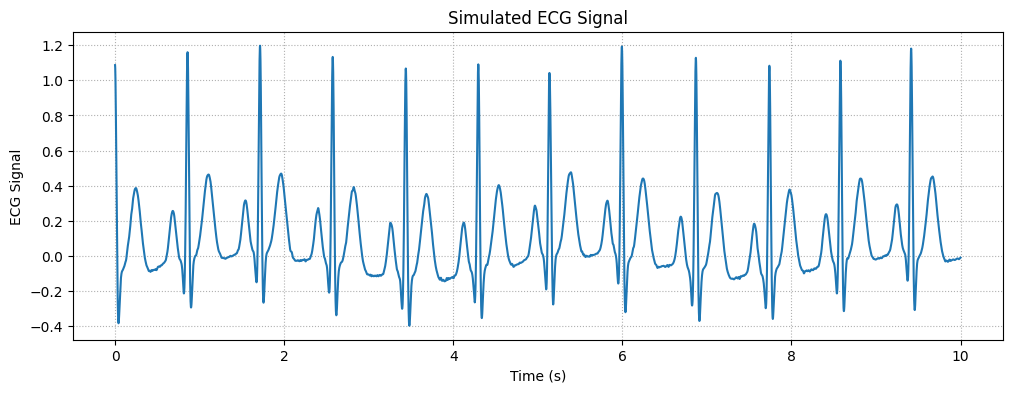

In [10]:
fs = int(1e3)

ecg_signal = nk.ecg_simulate(duration=10, sampling_rate=fs, heart_rate=70)
t = np.arange(len(ecg_signal)) / fs

plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal)
plt.xlabel('Time (s)')
plt.ylabel('ECG Signal')
plt.title('Simulated ECG Signal')
plt.grid(ls=":")
plt.show()


## 4. Detección de Complejos QRS y Picos R

Implementamos un algoritmo personalizado para detectar los picos R (máximos del complejo QRS) utilizando:
- Filtrado de la señal
- Derivada y cuadratura para realzar el QRS
- Integración de ventana móvil (MWI)
- Umbral adaptativo basado en estadísticas robustas

In [11]:
from scipy.signal import butter, filtfilt, find_peaks

### 4.1 Funciones Auxiliares

Definimos funciones para suavizado y refinamiento de picos detectados.

In [12]:
def moving_average(x, w):
    w = max(1, int(w))
    c = np.ones(w) / w
    return np.convolve(x, c, mode='same')


def _refine_peak(ecg, idx, half_win):
    """Refine approximate peak to the max of the raw ECG in ±half_win."""
    i0 = max(0, idx-half_win); i1 = min(len(ecg), idx+half_win+1)
    if i1-i0 <= 1: 
        return idx
    return i0 + np.argmax(ecg[i0:i1])

### 4.2 Algoritmo de Detección QRS

Implementación del detector QRS basado en el algoritmo de Pan-Tompkins modificado:
1. Derivada para realzar pendientes del QRS
2. Cuadratura para resaltar amplitudes
3. Integración de ventana móvil (~150 ms)
4. Umbral adaptativo usando mediana + MAD
5. Período refractario de 200 ms para evitar detecciones dobles

In [13]:
def detect_qrs_rpeaks(ecg, fs):
    """
    Returns r_peaks (sample indices), qrs_on (onsets), qrs_off (offsets).
    Method: bandpass(5–15 Hz) → derivative → square → MWI(150 ms) → adaptive threshold.
    """
    # Emphasize QRS bandwidth
    #qrs_bp = bandpass(ecg, fs, low=5.0, high=15.0, order=3)

    # PT-style preprocessing
    #der = np.append(np.diff(qrs_bp), 0)                    # derivative
    der = np.append(np.diff(ecg), 0)                    # derivative
    sq = der**2                                            # nonlinearity
    mwi = moving_average(sq, int(0.150*fs))                # ~150 ms integration

    # Adaptive threshold based on robust stats
    thr = np.median(mwi) + 1.5*np.median(np.abs(mwi - np.median(mwi)))  # median + 1.5*MAD

    # Refractory period ~200 ms to avoid double detections
    min_dist = int(0.2 * fs)
    pk_idx, _ = find_peaks(mwi, height=thr, distance=min_dist)

    # Refine each detection to true R on band-limited ECG (steeper & higher than raw)
    #r_peaks = np.array([_refine_peak(qrs_bp, p, half_win=int(0.05*fs)) for p in pk_idx], dtype=int)
    r_peaks = np.array([_refine_peak(ecg, p, half_win=int(0.05*fs)) for p in pk_idx], dtype=int)

    # QRS onset/offset from energy curve around each R
    qrs_on = []
    qrs_off = []
    half = int(0.12 * fs)  # ±120 ms search
    for r in r_peaks:
        i0 = max(0, r - half); i1 = min(len(mwi), r + half)
        seg = mwi[i0:i1]
        # define a local, conservative threshold
        loc_thr = np.median(seg)
        # onset: last index from r backwards where energy falls below local threshold
        on = i0 + np.where(seg[:(r-i0)][::-1] < loc_thr)[0]
        on = r - on[0] if len(on) else i0
        # offset: first index after r where energy falls below local threshold
        off = i0 + (np.where(seg[(r-i0):] < loc_thr)[0][0] if np.any(seg[(r-i0):] < loc_thr) else (i1 - i0 - 1))
        qrs_on.append(int(on))
        qrs_off.append(int(off))
    return r_peaks, np.array(qrs_on), np.array(qrs_off)
    

### 4.3 Aplicación del Detector y Visualización

Aplicamos el detector de picos R a la señal sintética y visualizamos los resultados.

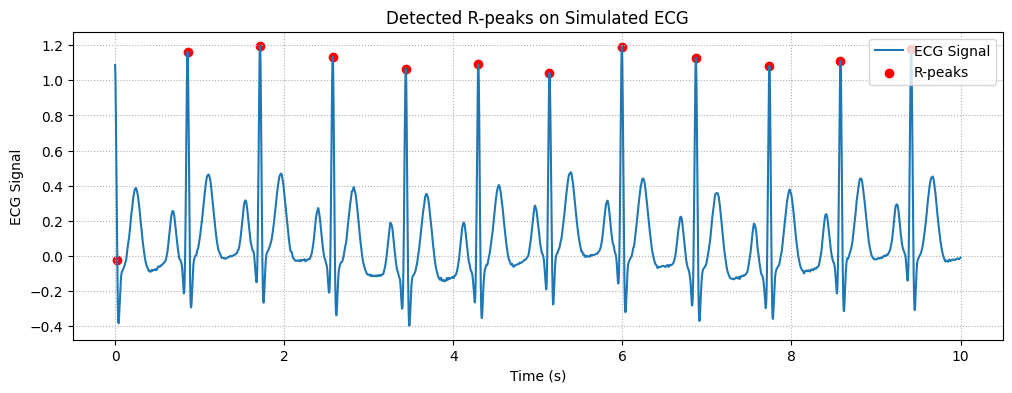

In [14]:
# Detect QRS peaks and boundaries
r_peaks, qrs_on, qrs_off = detect_qrs_rpeaks(ecg_signal, fs)

# Plot ECG signal and detected R-peaks
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label='ECG Signal')
plt.scatter(t[r_peaks], ecg_signal[r_peaks], color='red', label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('ECG Signal')
plt.title('Detected R-peaks on Simulated ECG')
plt.legend()
plt.grid(ls=":")
plt.show()

## 5. Análisis de Variabilidad Cardíaca

Calculamos los intervalos RR (tiempo entre picos R consecutivos) y la frecuencia cardíaca instantánea. Estos parámetros son fundamentales para el análisis de la variabilidad del ritmo cardíaco (HRV).

In [15]:
def rr_intervals_ms(r_peaks, fs):
    """Return RR intervals in milliseconds and heart rate series in bpm."""
    if len(r_peaks) < 2:
        return np.array([]), np.array([])
    rr_ms = np.diff(r_peaks) * 1000.0 / fs
    hr_bpm = 60_000.0 / rr_ms
    return rr_ms, hr_bpm


### 5.1 Cálculo de Intervalos RR y Frecuencia Cardíaca

Calculamos los intervalos RR en milisegundos y convertimos a latidos por minuto (bpm).

In [16]:
rr_ms, hr_bpm = rr_intervals_ms(r_peaks, fs)
rr_ms, hr_bpm

(array([832., 858., 859., 865., 857., 841., 857., 875., 870., 840., 836.]),
 array([72.11538462, 69.93006993, 69.84866123, 69.36416185, 70.01166861,
        71.34363853, 70.01166861, 68.57142857, 68.96551724, 71.42857143,
        71.77033493]))

### 5.2 Visualización de la Frecuencia Cardíaca

Graficamos la frecuencia cardíaca instantánea calculada a partir de los intervalos RR.

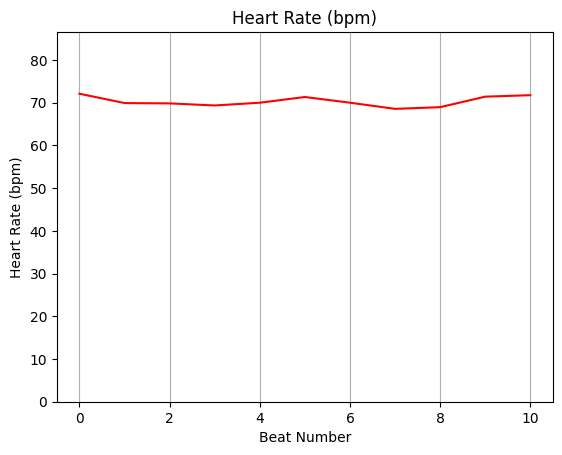

In [17]:
plt.plot(hr_bpm, c='red')
plt.title('Heart Rate (bpm)')
plt.xlabel('Beat Number')
plt.ylabel('Heart Rate (bpm)')
plt.ylim(0, max(hr_bpm)*1.2)
plt.grid(axis='x')
plt.show()

## 6. Detección de Onda P

La onda P representa la despolarización auricular y es crucial para detectar arritmias auriculares como la fibrilación auricular. Implementamos varios métodos de detección.

### 6.1 Método 1: Detector Basado en Wavelet y Envolvente de Hilbert

Este método utiliza:
- Filtrado paso-banda (0.5-15 Hz) para aislar frecuencias de la onda P
- Transformada wavelet (db6) para realzar componentes de 4-12 Hz
- Envolvente de Hilbert para detectar energía
- Filtros fisiológicos (duración 40-160 ms)

In [18]:
from scipy.signal import butter, filtfilt, find_peaks, hilbert, peak_widths
import pywt

In [19]:
def detect_pwaves_only(ecg, fs, r_peaks=None):
    """
    Detect P-wave peaks without requiring R-peak anchors.
    Optional: supply r_peaks to reject events too close to QRS.
    Returns:
      p_idx: sample indices of P-wave peaks
      p_env: envelope used for detection (for plotting/QA)
    """
    x_bp, x_p, env = enhance_p_band(ecg, fs)

    # Adaptive threshold on the envelope
    thr = robust_thr(env, k=2.0)

    # Physiologic constraints
    min_rr_like = int(0.20*fs)     # refractory ~200 ms (avoid double P)
    p_idx, props = find_peaks(env, height=thr, distance=min_rr_like, prominence=np.std(env)*0.2)

    # Width filter: expect ~60–120 ms (allow 40–160 ms to be tolerant)
    if len(p_idx) > 0:
        w_res = peak_widths(env, p_idx, rel_height=0.5)
        widths = w_res[0] / fs  # in seconds
        keep = (widths >= 0.040) & (widths <= 0.160)
        p_idx = p_idx[keep]

    # Optional: reject candidates too close to QRS (if R provided)
    if r_peaks is not None and len(p_idx) > 0 and len(r_peaks) > 0:
        mask = np.ones_like(p_idx, dtype=bool)
        for i, p in enumerate(p_idx):
            # If within ±60 ms of an R, discard (likely part of QRS/T)
            if np.any(np.abs(r_peaks - p) <= int(0.06*fs)):
                mask[i] = False
        p_idx = p_idx[mask]

    return p_idx.astype(int), env, x_bp, x_p

In [20]:

def butter_bandpass(low, high, fs, order=3):
    nyq = 0.5*fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return b, a

def bandpass(x, fs, low=0.5, high=15.0, order=3):
    b, a = butter_bandpass(low, high, fs, order)
    return filtfilt(b, a, x)

def robust_thr(x, k=2.2):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med + k*mad

def enhance_p_band(ecg, fs):
    """
    Bandpass (0.5–15 Hz) to suppress drift & HF noise, then
    wavelet detail reconstruction in ~4–12 Hz and amplitude envelope.
    """
    x = bandpass(ecg, fs, 0.5, 15.0, order=3)

    # Choose a wavelet level whose pseudo-band covers ~4–12 Hz.
    # Heuristic: level ≈ round(log2(fs/24)) bounded to [2,5]
    level = int(np.clip(np.rint(np.log2(fs/24.0)), 2, 5))
    coeffs = pywt.wavedec(x, 'db6', level=level)

    # Keep only one detail level near the P band
    keep = [np.zeros_like(c) for c in coeffs]
    target_detail = len(coeffs) - level  # detail index to keep
    keep[target_detail] = coeffs[target_detail]
    x_p = pywt.waverec(keep, 'db6')
    x_p = x_p[:len(x)]

    # Envelope of the enhanced signal (smooth energy)
    env = np.abs(hilbert(x_p))
    # Light smoothing (~30 ms) to stabilize envelope
    w = max(1, int(0.03*fs))
    env = np.convolve(env, np.ones(w)/w, mode='same')
    return x, x_p, env


#### Aplicación del Detector de Onda P (Método 1)

In [21]:
p_idx, p_env, x_bp, x_p = detect_pwaves_only(ecg_signal, fs)

# Quick sanity print
print(f"Detected {len(p_idx)} P candidates at samples:", p_idx)


Detected 12 P candidates at samples: [  90  855 1723 2588 3452 4341 5146 6015 6874 7732 8635 9465]


#### Visualización de Resultados (Método 1)

Mostramos la señal filtrada, el realce wavelet, la envolvente y las detecciones de onda P.

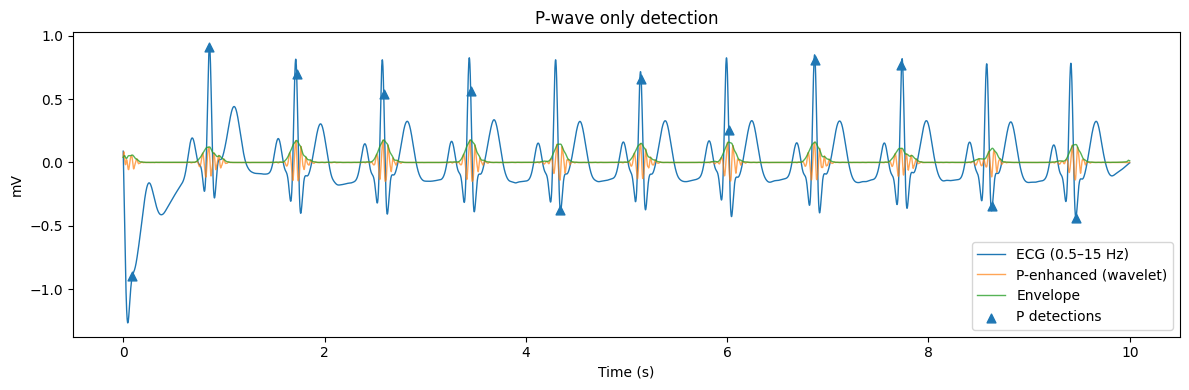

In [22]:
plt.figure(figsize=(12,4))
plt.plot(t, x_bp, lw=1, label='ECG (0.5–15 Hz)')
plt.plot(t, x_p, lw=1, alpha=0.7, label='P-enhanced (wavelet)')
plt.plot(t, p_env, lw=1, alpha=0.8, label='Envelope')
plt.scatter(t[p_idx], x_bp[p_idx], s=40, marker='^', label='P detections', zorder=3)
plt.legend(); plt.xlabel('Time (s)'); plt.ylabel('mV'); plt.title('P-wave only detection')
plt.tight_layout(); plt.show()

### 6.3 Método 2: Detección con Neurokit2

Usamos la librería Neurokit2 que implementa algoritmos validados para detección de ondas P.

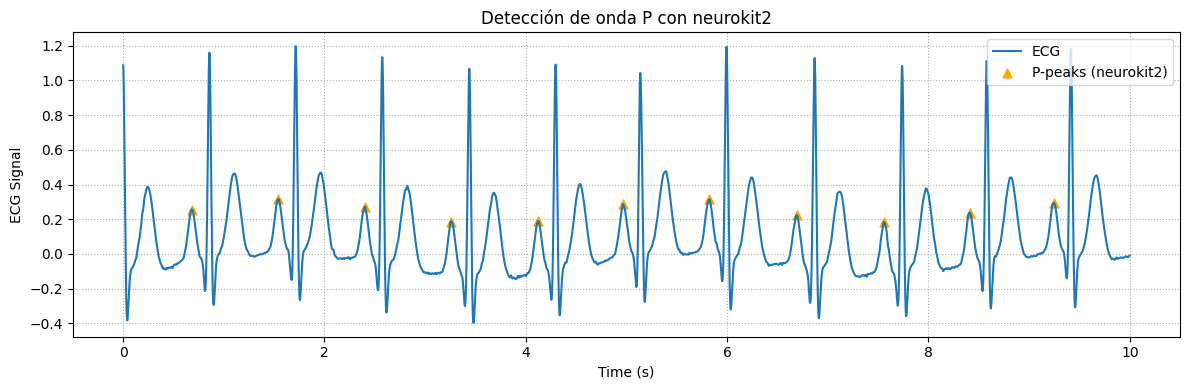

In [23]:
# Detección de la onda P usando neurokit2
signals, info_nk = nk.ecg_process(ecg_signal, sampling_rate=fs)
p_peaks_nk = info_nk["ECG_P_Peaks"]

# Graficar ECG y detecciones de onda P
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[p_peaks_nk], ecg_signal[p_peaks_nk], color='orange', marker='^', s=40, label="P-peaks (neurokit2)")
plt.xlabel("Time (s)")
plt.ylabel("ECG Signal")
plt.title("Detección de onda P con neurokit2")
plt.legend()
plt.grid(ls=":")
plt.tight_layout()
plt.show()

---

# 7. Análisis de Señales ECG Reales.

En esta sección analizamos señales ECG reales de la base de datos ECG signals (1000 fragments) 
https://data.mendeley.com/datasets/7dybx7wyfn/3

## 7.1 Carga de Datos Reales

In [24]:
import pickle

In [25]:
!dir

 El volumen de la unidad D no tiene etiqueta.
 El n�mero de serie del volumen es: 08C4-45BE

 Directorio de d:\CODES\Tesis-MIA-UNI\notebooks\TESTS\EKG_processing

12/11/2025  10:03 a.m.    <DIR>          .
12/11/2025  10:03 a.m.    <DIR>          ..
12/11/2025  02:29 p.m.           649,788 ecg_Detection1.ipynb
               1 archivos        649,788 bytes
               2 dirs  513,416,458,240 bytes libres


In [26]:
path_db = "../../ECG_DATASET/dataset_ekg.pkl"

with open(path_db, "rb") as f:
    dataset = pickle.load(f)

dataset

{'NSR': array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
          0.13048524,  0.11548524],
        [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
          0.33548524,  0.31548524],
        [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
         -0.20451476, -0.20451476],
        ...,
        [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
         -0.58951476, -0.58951476],
        [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
         -0.44451476, -0.40451476],
        [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
          0.20048524,  0.18548524]], shape=(283, 3600)),
 'VT': array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
         -0.00212931,  0.01787069],
        [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
          0.84787069,  0.86787069],
        [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
          0.06787069,  0.10287069],
        ...,
        [ 0.17287069, 

In [27]:
dataset.keys()


dict_keys(['NSR', 'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW', 'PVC', 'Bigeminy', 'Trigeminy'])

### 7.2 Selección de Señal para Análisis

Seleccionamos una señal de Trigeminia (tipo de arritmia ventricular) para analizar.

In [28]:
ecg_signal = dataset["Trigeminy"][0,:]
ecg_signal

array([0.21956848, 0.22456848, 0.21956848, ..., 0.19956848, 0.18956848,
       0.19456848], shape=(3600,))

In [29]:
ecg_signal.shape

(3600,)

### 7.3 Configuración de Parámetros

Configuramos la frecuencia de muestreo (360 Hz para MIT-BIH) y el vector de tiempo.

In [30]:
# Detección de la onda P usando neurokit2
fs = 360
t = np.arange(ecg_signal.shape[0]) / fs

### 7.4 Visualización de la Señal Real

Graficamos la señal ECG real para observar su morfología y características.

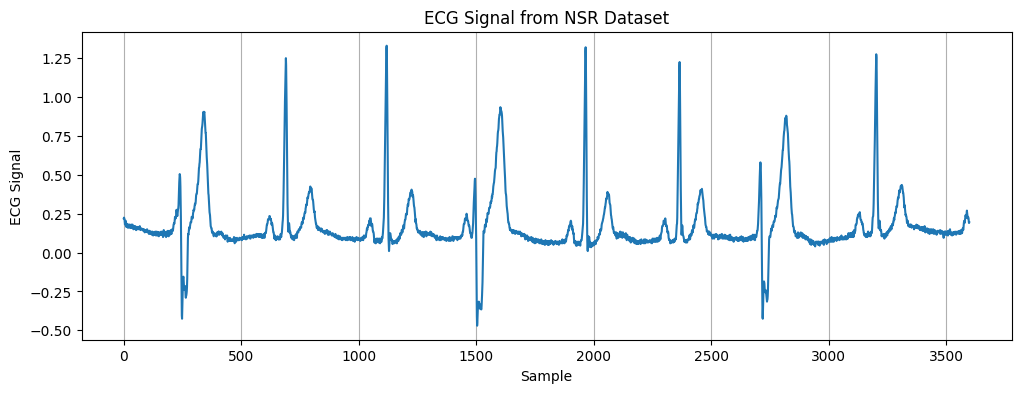

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal)
plt.xlabel("Sample")
plt.ylabel("ECG Signal")
plt.title("ECG Signal from NSR Dataset")
plt.grid(axis='x')

### 7.5 Detección de Ondas P en Señal Real

Aplicamos el detector de ondas P de Neurokit2 a la señal real y visualizamos los resultados. La detección correcta de ondas P es crucial para identificar arritmias auriculares.

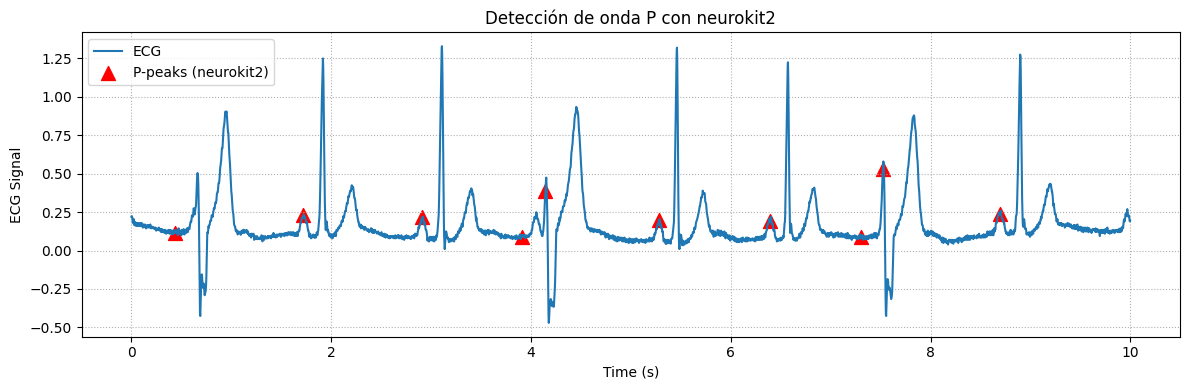

In [32]:
# Detección de la onda P usando neurokit2
signals, info_nk = nk.ecg_process(ecg_signal, sampling_rate=fs)
p_peaks_nk = info_nk["ECG_P_Peaks"]

# Graficar ECG y detecciones de onda P
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[p_peaks_nk], ecg_signal[p_peaks_nk], color='red', marker='^', s=100, label="P-peaks (neurokit2)")
plt.xlabel("Time (s)")
plt.ylabel("ECG Signal")
plt.title("Detección de onda P con neurokit2")
plt.legend()
plt.grid(ls=":")
plt.tight_layout()
plt.show()